# Classification and Captioning Aircraft Damage Using Pretrained Models


## **Introduction**

In this project, we will classify aircraft damage using a pre-trained VGG16 model and generate captions using a Transformer-based pretrained model.

## **Project Overview**

Aircraft damage detection is essential for maintaining the safety and longevity of aircraft. Traditional manual inspection methods are time-consuming and prone to human error. This project aims to automate the classification of aircraft damage into two categories: "dent" and "crack." For this, we will utilize feature extraction with a pre-trained VGG16 model to classify the damage from aircraft images. Additionally, we will use a pre-trained Transformer model to generate captions and summaries for the images.

## **Aim of the Project**

The goal of this project is to develop an automated model that accurately classifies aircraft damage from images. By the end of the project, you will have trained and evaluated a model that utilizes feature extraction from VGG16 for damage classification. This model will be applicable in real-world damage detection within the aviation industry. Furthermore, the project will showcase how we can use a Transformer-based model to caption and summarize images, providing a detailed description of the damage.

## **Final Output**

- A trained model capable of classifying aircraft images into "dent" and "crack" categories, enabling automated aircraft damage detection.


We will be using the [Aircraft dataset](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/ZjXM4RKxlBK9__ZjHBLl5A/aircraft-damage-dataset-v1.tar).
The dataset is taken from the here (Original Source): [Roboflow Aircraft Dataset](https://universe.roboflow.com/youssef-donia-fhktl/aircraft-damage-detection-1j9qk) Provided by a Roboflow user, License: CC BY 4.


<h2>Table of Contents</h2>
 
<div class="alert alert-block alert-info" style="margin-top: 20px">
    <p><font size="5">Part 1 - Classification Problem: Classifying the defect on the aircraft as 'dent' or 'crack'</p>
<font size="3">
        1. <a href="#1.1-Dataset-Preparation">1.1 Dataset Preparation</a><br>
        2. <a href="#1.2-Data-Preprocessing">1.2 Data Preprocessing</a><br>
        3. <a href="#1.3-Model-Definition">1.3 Model Definition</a><br>
        4. <a href="#1.4-Model-Training">1.4 Model Training</a><br>
        5. <a href="#1.5-Visualizing-Training-Results">1.5 Visualizing Training Results</a><br>
        6. <a href="#1.6-Model-Evaluation">1.6 Model Evaluation</a><br>
        7. <a href="#1.7-Visualizing-Predictions">1.7 Visualizing Predictions</a><br>
    <br>
<p><font size="5">Part 2: Image Captioning and Summarization using BLIP Pretrained Model</p>
<font size="3">
        1. <a href="#2.1-Loading-BLIP-Model">2.1 Loading BLIP Model</a><br>
        2. <a href="#2.2-Generating-Captions-and-Summaries">2.2 Generating Captions and Summaries</a><br>
        <br>
    


# 1.1 Dataset-Preparation



 ### Task List
To achieve the above objectives, we will complete the following tasks:

- Task 1: Create a `valid_generator` using the `valid_datagen` object
- Task 2: Create a `test_generator` using the `test_datagen` object
- Task 3: Load the VGG16 model
- Task 4: Compile the model
- Task 5: Train the model
- Task 6: Plot accuracy curves for training and validation sets 
- Task 7: Visualizing the results 
- Task 8: Implement a Helper Function to Use the Custom Keras Layer
- Task 9: Generate a caption for an image using the using BLIP pretrained model
- Task 10: Generate a summary of an image using BLIP pretrained model


## Setup


In [1]:
import warnings
warnings.filterwarnings('ignore')

### Installing Required Libraries


In [3]:
!pip install pandas==2.2.3
!pip install tensorflow==2.17.1
!pip install pillow==11.1.0
!pip install matplotlib==3.9.2
!pip install transformers==4.38.2
!pip install torch

  Using cached tensorflow-2.17.1-cp39-cp39-win_amd64.whl.metadata (3.3 kB)
  Using cached tensorflow_intel-2.17.1-cp39-cp39-win_amd64.whl.metadata (5.0 kB)
  Using cached tensorboard-2.17.1-py3-none-any.whl.metadata (1.6 kB)
Using cached tensorflow-2.17.1-cp39-cp39-win_amd64.whl (7.5 kB)
Using cached tensorflow_intel-2.17.1-cp39-cp39-win_amd64.whl (382.2 MB)
   ---------------------------------------- 0.0/5.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/5.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/5.5 MB ? eta -:--:--
   - -------------------------------------- 0.3/5.5 MB ? eta -:--:--
   --- ------------------------------------ 0.5/5.5 MB 985.5 kB/s eta 0:00:06
   ----- ---------------------------------- 0.8/5.5 MB 1.0 MB/s eta 0:00:05
   ------- -------------------------------- 1.0/5.5 MB 1.1 MB/s eta 0:00:05
   --------- ------------------------------ 1.3/5.5 MB 1.1 MB/s eta 0:00:04
   ----------- ---------------------------- 1.6/5.5 MB 1.

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-cpu 2.16.2 requires tensorflow-intel==2.16.2; platform_system == "Windows", but you have tensorflow-intel 2.17.1 which is incompatible.


#### Suppress the tensorflow warning messages
We use the following code to  suppress the warning messages due to use of CPU architechture for tensoflow.

You may want to **comment out** these lines if you are using the GPU architechture


In [4]:
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

### Importing Required Libraries


In [5]:
import zipfile
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten
from keras.applications import VGG16
from keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing import image
import random

In [6]:
# Set seed for reproducibility
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

## <a id='toc1_'> </a> [Part 1 - Classification Problem: Classifying the defect on the aircraft as 'dent' or 'crack'](#toc1_) 

### <a id='toc1_1_'></a> [1.1 Dataset Preparation](#toc1_) 

The first step is to load and prepare the dataset of aircraft images. These images are labeled either as 'dent' or 'crack'. We will also split the dataset into training, validation, and test sets.




In [7]:
#Set the batch size,epochs
batch_size = 32
n_epochs = 5
img_rows, img_cols = 224, 224
input_shape = (img_rows, img_cols, 3)

Extract the Dataset:
Unzip the dataset to the current directory, creating directories for training, testing, and validation splits.


In [10]:
import tarfile
import urllib.request
import os
import shutil

# URL of the tar file
url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/ZjXM4RKxlBK9__ZjHBLl5A/aircraft-damage-dataset-v1.tar"

# Define the path to save the file
tar_filename = "aircraft_damage_dataset_v1.tar"
extracted_folder = "aircraft_damage_dataset_v1"  # Folder where contents will be extracted

# Download the tar file
urllib.request.urlretrieve(url, tar_filename)
print(f"Downloaded {tar_filename}. Extraction will begin now.")

# Check if the folder already exists
if os.path.exists(extracted_folder):
    print(f"The folder '{extracted_folder}' already exists. Removing the existing folder.")
    
    # Remove the existing folder to avoid overwriting or duplication
    shutil.rmtree(extracted_folder)
    print(f"Removed the existing folder: {extracted_folder}")

# Extract the contents of the tar file
with tarfile.open(tar_filename, "r") as tar_ref:
    tar_ref.extractall()  # This will extract to the current directory
    print(f"Extracted {tar_filename} successfully.")


Downloaded aircraft_damage_dataset_v1.tar. Extraction will begin now.
The folder 'aircraft_damage_dataset_v1' already exists. Removing the existing folder.


PermissionError: [WinError 5] Access is denied: 'aircraft_damage_dataset_v1\\test\\crack'

The folder structure looks as follows:

```python
aircraft_damage_dataset_v1/
├── train/
│   ├── dent/
│   └── crack/
├── valid/
│   ├── dent/
│   └── crack/
└── test/
    ├── dent/
    └── crack/

```



In [9]:
# Define directories for train, test, and validation splits
extract_path = "aircraft_damage_dataset_v1"
train_dir = os.path.join(extract_path, 'train')
test_dir = os.path.join(extract_path, 'test')
valid_dir = os.path.join(extract_path, 'valid')

## 1.2 Data Preprocessing

Create data generators for training, validation, and testing datasets.

First,we will create ImageDataGenerators used for training, validation and testing.
The ImageDataGenerator class is part of Keras. It is a powerful utility for real-time image data augmentation, preprocessing, and feeding data into deep learning models during training. This class is particularly useful when working with image datasets that are too large to fit into memory all at once, or when you want to augment your dataset  to improve model generalization. 

We will create instances of the ImageDataGenerator class. Each instance corresponds to one of the datasets: training, validation, and testing.


In [11]:
# Create ImageDataGenerators to preprocess the data
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

Next, we use flow_from_directory() method to load the images from directory and generate the training dataset. The flow_from_directory() method is part of the ImageDataGenerator class in Keras, and it plays a crucial role in automating the process of loading, preprocessing, and batching images for training, validation, and testing.
We use the train_datagen object to load and preprocess the training images. Specifically, the flow_from_directory() function is used to read images directly from the directory and generate batches of data that will be fed into the model for training.


In [12]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_rows, img_cols),   # Resize images to the size VGG16 expects
    batch_size=batch_size,
    seed = seed_value,
    class_mode='binary',
    shuffle=True # Binary classification: dent vs crack
)

Found 103 images belonging to 1 classes.


## **Task 1: Create a `valid_generator` using the `valid_datagen` object**


In [ ]:
valid_generator = valid_datagen.flow_from_directory(
    directory=valid_dir,
    class_mode = 'binary',
    seed = seed_value,
    batch_size = batch_size,
    shuffle=False,
    target_size=(img_rows, img_cols)
)

Found 96 images belonging to 2 classes.


## **Task 2: Create a `test_generator` using the `test_datagen` object**


In [53]:
#Write your code here
test_generator = test_datagen.flow_from_directory(
    directory = test_dir,
    class_mode = 'binary',
    seed = seed_value,
    batch_size = batch_size,
    shuffle = False,
    target_size = (img_rows, img_cols)
)

Found 50 images belonging to 2 classes.


## 1.3 Model Definition

Here, we define the model architecture by using a pre-trained VGG16 model as the base, adding custom layers on top for binary classification of 'dent' and 'crack' types of damage.


## **Task 3: Load the pre-trained model VGG16**



In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, 3))

Now, we modify the VGG16 model for our specific classification task. We extract the output from the last layer of the pre-trained VGG16 model, and then create a new model with this modified output. Then we will freeze the base VGG16 model layers so that their weights will not be updated during training.


In [55]:
output = base_model.layers[-1].output
output = keras.layers.Flatten()(output)
base_model = Model(base_model.input, output)

# Freeze the base VGG16 model layers
for layer in base_model.layers:
    layer.trainable = False

After using VGG16 as a feature extractor, we add our own classifier on top of the VGG16 model. This involves adding fully connected layers (Dense), activation functions (like ReLU), and sometimes Dropout layers to avoid overfitting.
Here, we are adding two dense layers with 512 units each, followed by a Dropout layer, and finally, a Dense layer with one unit and a sigmoid activation to output the probability for binary classification ("dent" vs "crack").


In [56]:
# Build the custom model
model = Sequential()
model.add(base_model)
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

## **Task 4: Compile the model**



In [57]:
# Write your code here
model.compile(
    optimizer = Adam(learning_rate=0.0001),
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

## 1.4 Model Training

- This section covers the process of training the model using the prepared dataset.


## Task 5: Model Training


In [ ]:
history = model.fit(
    train_generator,
    epochs = n_epochs,
    validation_data = valid_generator
)

Epoch 1/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 4s/step - accuracy: 1.0000 - loss: 8.6151e-07 - val_accuracy: 0.5000 - val_loss: 8.8795
Epoch 2/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 4s/step - accuracy: 1.0000 - loss: 5.0912e-07 - val_accuracy: 0.5000 - val_loss: 9.4421
Epoch 3/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 4s/step - accuracy: 1.0000 - loss: 1.0027e-06 - val_accuracy: 0.5000 - val_loss: 9.8362
Epoch 4/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 4s/step - accuracy: 1.0000 - loss: 2.6096e-07 - val_accuracy: 0.5000 - val_loss: 10.1116
Epoch 5/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 4s/step - accuracy: 1.0000 - loss: 2.5721e-08 - val_accuracy: 0.5000 - val_loss: 10.3032


In [27]:
# Access the training history
train_history = model.history.history  # After training

## 1.5 Visualizing Training Results

- After training the model, we visualize the training and validation accuracy and loss to understand the model's learning process.


### Plot loss curves for training and validation sets


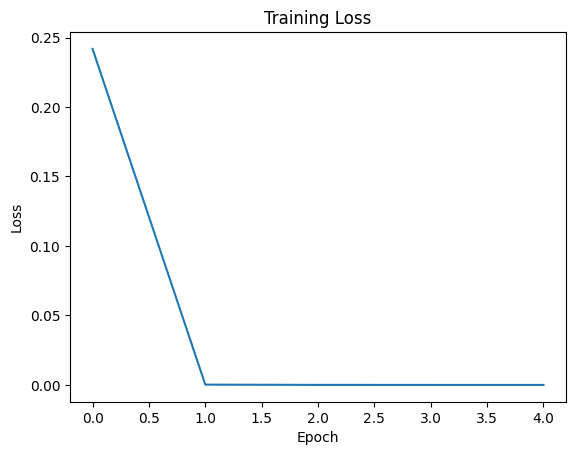

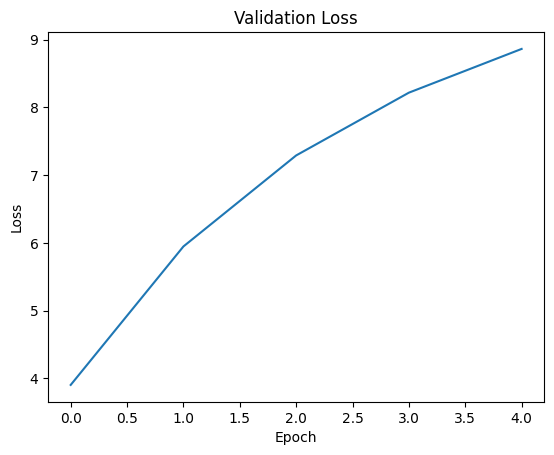

In [28]:
# Plot the loss for both training and validation
plt.title("Training Loss")
plt.ylabel("Loss")
plt.xlabel('Epoch')
plt.plot(train_history['loss'])
plt.show()

plt.title("Validation Loss")
plt.ylabel("Loss")
plt.xlabel('Epoch')
plt.plot(train_history['val_loss'])
plt.show()

## Task 6: Plot accuracy curves for training and validation sets



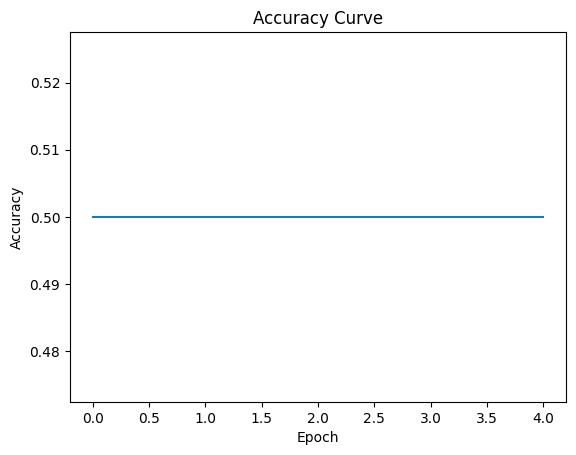

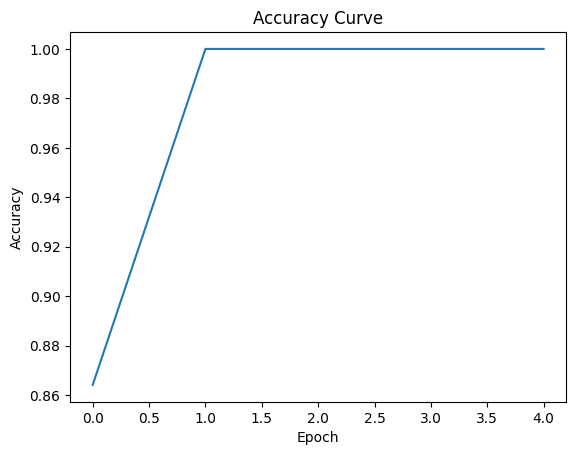

In [36]:
# Write your code here
plt.title("Accuracy Curve")
plt.ylabel("Accuracy")
plt.xlabel('Epoch')
plt.plot(train_history['val_accuracy'], label="Validation Accuracy")
plt.show()

plt.title("Accuracy Curve")
plt.ylabel("Accuracy")
plt.xlabel('Epoch')
plt.plot(train_history['accuracy'], label="Training Accuracy")
plt.show()


## 1.6 Model Evaluation

Now we evaluate the trained model on the test dataset. Calculates test loss and accuracy by evaluating the test generator. Predictions are made for the test dataset, and the results are compared to true labels.


In [31]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7812 - loss: 4.0527
Test Loss: 4.0527
Test Accuracy: 0.7812


 ## 1.7 Visualizing Predictions

Display test images alongside their true and predicted labels.

True labels and predictions are retrieved.
Images are displayed with labels for visual inspection of model performance.


In [32]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Function to plot a single image and its prediction
def plot_image_with_title(image, model, true_label, predicted_label, class_names):
    plt.figure(figsize=(6, 6))
    plt.imshow(image)

    # Convert labels from one-hot to class indices if needed, but for binary labels it's just 0 or 1
    true_label_name = class_names[true_label]  # Labels are already in class indices
    pred_label_name = class_names[predicted_label]  # Predictions are 0 or 1

    plt.title(f"True: {true_label_name}\nPred: {pred_label_name}")
    plt.axis('off')
    plt.show()

# Function to test the model with images from the test set
def test_model_on_image(test_generator, model, index_to_plot=0):
    # Get a batch of images and labels from the test generator
    test_images, test_labels = next(test_generator)

    # Make predictions on the batch
    predictions = model.predict(test_images)

    # In binary classification, predictions are probabilities (float). Convert to binary (0 or 1)
    predicted_classes = (predictions > 0.5).astype(int).flatten()

    # Get the class indices from the test generator and invert them to get class names
    class_indices = test_generator.class_indices
    class_names = {v: k for k, v in class_indices.items()}  # Invert the dictionary

    # Specify the image to display based on the index
    image_to_plot = test_images[index_to_plot]
    true_label = test_labels[index_to_plot]
    predicted_label = predicted_classes[index_to_plot]

    # Plot the selected image with its true and predicted labels
    plot_image_with_title(image=image_to_plot, model=model, true_label=true_label, predicted_label=predicted_label, class_names=class_names)




## **Task 7: Visualizing the results**


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


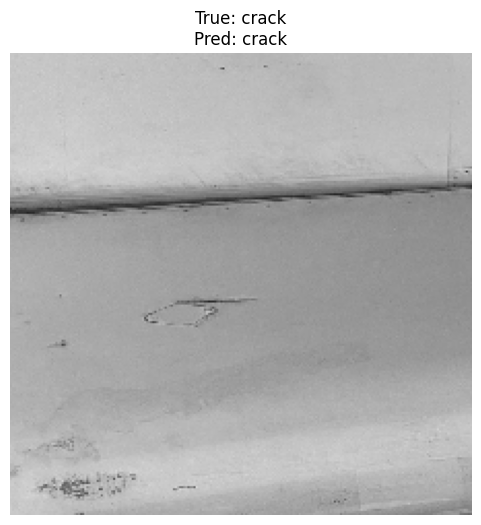

In [33]:
#Write your code here

test_model_on_image(test_generator, model, index_to_plot=1)